# Actor Critic

In [16]:
# Source: https://github.com/mszhanyi/pymultiprocessdemo/blob/main/demos/mycellmagic.py
from IPython.core.magic import register_cell_magic


@register_cell_magic
def save2file(line, cell):
    "save python code block to a file"
    with open(line, "wt") as fd:
        fd.write(cell)

In [17]:
%%save2file actor_critic.py

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.multiprocessing as mp
from torch.nn import functional as F


class ActorCritic(torch.nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = torch.nn.Linear(4, 25)
        self.l2 = torch.nn.Linear(25, 50)
        # The output is an action.
        self.actor_lin1 = torch.nn.Linear(50, 2)
        self.l3 = torch.nn.Linear(50, 25)
        # The output is the reward.
        self.critic_lin1 = torch.nn.Linear(25, 1)

    def forward(self, X):
        X = F.normalize(X, dim=0)
        y = F.relu(self.l1(X))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y), dim=0)
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c))
        return actor, critic


def run_episode(model, optimizer, clc=0.1, gamma=0.95, max_episodes=500):
    values = []
    log_probs = []
    rewards = []
    env = gym.make("CartPole-v1")
    observation = env.reset()
    for _ in range(max_episodes):
        state = torch.Tensor(observation)
        policy, value = model(state)
        values.append(value)

        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        log_prob = policy.view(-1)[action]
        log_probs.append(log_prob)

        observation, _reward, done, info = env.step(action.detach().long().item())
        reward = -10 if done else 1
        rewards.append(reward)
        if done:
            break

    rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)
    log_probs = torch.stack(log_probs).flip(dims=(0,)).view(-1)
    values = torch.stack(values).flip(dims=(0,)).view(-1)
    returns = []
    ret = torch.Tensor([0])
    for r in range(rewards.shape[0]):
        ret = rewards[r] + gamma * ret
        returns.append(ret)
    returns = torch.stack(returns).view(-1)
    returns = F.normalize(returns, dim=0)
    actor_loss = -log_probs * (returns - values.detach())
    critic_loss = torch.pow(values - returns, 2)
    loss = actor_loss.sum() + clc * critic_loss.sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return actor_loss, critic_loss, len(rewards)


def worker(worker_id, model, counter, params):
    optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
    for i in range(params["epochs"]):
        actor_loss, critic_loss, episodes = run_episode(model, optimizer)
        counter.value = counter.value + 1

In [18]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.multiprocessing as mp
from tqdm.notebook import trange

from actor_critic import ActorCritic, worker

if __name__ == "__main__":
    actor_critic = ActorCritic()
    actor_critic.share_memory()
    processes = []
    params = {
        "epochs": 1000,
        "n_workers": 4,
    }

    counter = mp.Value("i", 0)
    for i in range(params["n_workers"]):
        p = mp.Process(target=worker, args=(i, actor_critic, counter, params))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
    for p in processes:
        p.terminate()
    print(counter.value, processes[0].exitcode)

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-deep-reinforcement-learning-in-acti-HlKDIbnR-py3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-deep-reinforcement-learning-in-acti-HlKDIbnR-py3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-deep-reinforcement-learning-in-acti-HlKDIbnR-py3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resour

3998 0


In [19]:
def evaluate(model, max_episodes=1000, max_trajectory=1000):
    env = gym.make("CartPole-v1")
    scores = []
    for episode in trange(max_episodes):
        observation = env.reset()
        transitions = []

        for t in range(max_trajectory):
            state = torch.from_numpy(observation)
            with torch.no_grad():
                policy, _value = model(state)
            logits = policy.view(-1)
            action_dist = torch.distributions.Categorical(logits=logits)
            action = action_dist.sample()
            observation, reward, done, _info = env.step(action.item())
            transitions.append((state, action, t + 1))
            if done:
                break
        scores.append(len(transitions))
    return scores

  0%|          | 0/1000 [00:00<?, ?it/s]

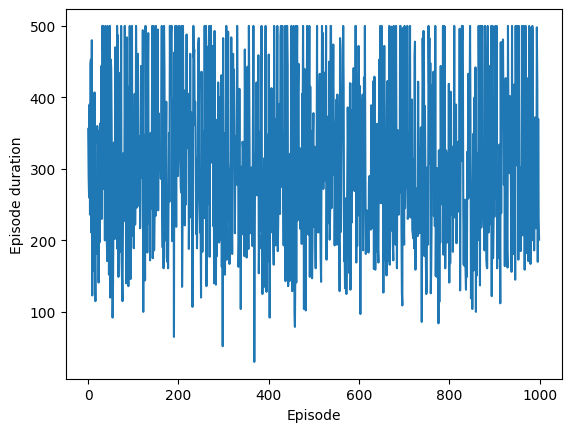

In [20]:
scores = evaluate(actor_critic)
fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode duration");

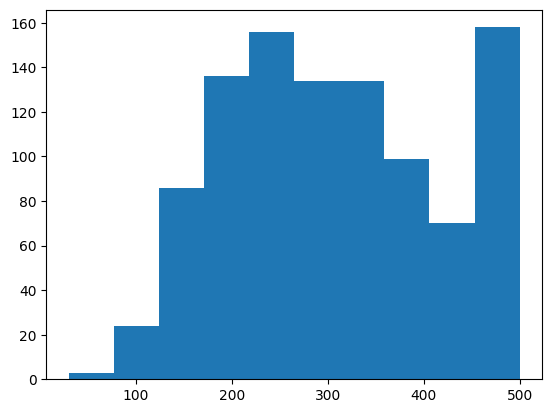

In [22]:
plt.hist(scores);